# Предварительный анализ тарифов Мегалайна

В данном проекте мы провели анализ двух тарифов федерального оператора сотовой связи «Мегалайн» для с целью корректировки рекламного бюджета. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент просит выяснить, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


1. [Обзор данных](#first)
2. [Подготовка данных](#second) 
3. [Анализ данных](#third)
4. [Проверка гипотез](#fourth)
5. [Общий вывод](#fifth)

## Обзор данных <a id="first"></a>

Импортируем требуемые для выполнения проекта библиотеки и открываем датасеты. Так же зараннее отключим предупреждения об ошибках.

In [1]:
import pandas as pd 
import numpy as np
from scipy import stats as st
import warnings
calls = pd.read_csv('/Users/alex/Desktop/питон/data/Проект по статистическому анализу/calls.csv')
internet = pd.read_csv('/Users/alex/Desktop/питон/data/Проект по статистическому анализу/internet.csv')
messages = pd.read_csv('/Users/alex/Desktop/питон/data/Проект по статистическому анализу/messages.csv')
tariffs = pd.read_csv('/Users/alex/Desktop/питон/data/Проект по статистическому анализу/tariffs.csv')
users = pd.read_csv('/Users/alex/Desktop/питон/data/Проект по статистическому анализу/users.csv')
warnings.filterwarnings("ignore") 

Выведем названия столбцов всех датасетов для проверки правильности написания

In [2]:
display(f'calls columns: {set(calls.columns)}')
display(f'internet columns: {set(internet.columns)}')
display(f'messages columns: {set(messages.columns)}')
display(f'tariffs columns: {set(tariffs.columns)}')
display(f'users columns: {set(users.columns)}')

"calls columns: {'user_id', 'id', 'duration', 'call_date'}"

"internet columns: {'session_date', 'user_id', 'id', 'Unnamed: 0', 'mb_used'}"

"messages columns: {'user_id', 'id', 'message_date'}"

"tariffs columns: {'rub_per_minute', 'rub_monthly_fee', 'tariff_name', 'mb_per_month_included', 'rub_per_gb', 'rub_per_message', 'minutes_included', 'messages_included'}"

"users columns: {'user_id', 'age', 'churn_date', 'city', 'last_name', 'first_name', 'tariff', 'reg_date'}"

В целом всё в порядке, названия написаны снейк_кейсом. Единственное исключение столбец `Unnamed:0` таблицы `internet`написанный неправильнов. По названию похоже, что столбец попал в таблицу в результате какой-либо ошибки.

In [3]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Да, столбец бесполезе - удаляем.

In [4]:
internet.drop('Unnamed: 0', axis=1)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


## Подготовка данных<a id="second"></a>

Мне показалось удобнее обозревать датасет рядышком с его подготовкой, дабы не скролить постоянно туда-сюда всю тетрадку, и посему методы info, head, describe будут применяться в разделе подготовки данных.

In [5]:
print(users.info()) #Выводим общую информацию о датасете
print(users.head(10)) #Выводим первые 10 строк датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
   user_id  age churn_date              city first_name  last_name  \
0     1000   52        NaN         Краснодар     Рафаил  Верещагин   
1     1001   41        NaN            Москва       Иван       Ежов   
2     1002   59        NaN       Стерлитамак    Евгений  Абрамович   
3     1003   23        NaN            Москва      Белла   Белякова   
4     1004   68        NaN       Новокузнецк    Татьяна   Авдеенко   
5     1005   67     

Видим пропуски в столбце "churn_date ", но для нашего исследования нам этот столбец не требуется, потому убирать эти пропуски мы не будем.

In [6]:
display(calls.info()) #Выводим общую информацию о датасете
display(calls.head(10)) #Выводим первые 10 строк датасета

calls['duration'] = np.ceil(calls['duration'])#округляем длительности звонков в большую сторону
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') #Меняем формат данных в столбце "call_date" на datetime
display(calls.isna().sum()) #смотрим есть ли пропуски в датасете
display(calls.duplicated().sum()) #проверяем на наличие явных дубликатов
display(calls['user_id'].value_counts().count())#смотрим количество уникальных значений в столбце "user_id"
calls['month'] = calls['call_date'].dt.month #создаем столбец с месяцами звонков
calls_groupied = calls.pivot_table(index=['user_id','month'], values= 'duration',aggfunc=['count','sum']).reset_index() #группируем данные столбца "duration" по столбцам "user_id" и "month" и считаем количество звонков в месяц и сумму длительностей в месяц
calls_groupied.columns = ['user_id','month','calls','minutes_sum'] #меняем названия столбцов получившегося датасета
calls_groupied['minutes_sum'] = calls_groupied['minutes_sum'].astype('int') #меняем тип данных на целочисленный в столбце "minutes_sum"
calls_groupied

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


id           0
call_date    0
duration     0
user_id      0
dtype: int64

0

492

,user_id,month,calls,minutes_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
...,...,...,...,...
3169,1498,10,41,247
3170,1499,9,9,70
3171,1499,10,68,449
3172,1499,11,74,612


проделываем всё то же самое с таблицей "internet"

In [7]:
display(internet.info())
display(internet.head(10))
internet = internet.loc[:, 'id':'user_id']
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month
display(internet.head(10))
display(internet.isna().sum())
display(internet['user_id'].value_counts().count())
display(calls.duplicated().sum())
internet_groupied = internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum')
internet_groupied

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
5,1000_5,399.97,2018-10-02,1000,10
6,1000_6,540.08,2018-09-07,1000,9
7,1000_7,415.70,2018-07-11,1000,7
8,1000_8,505.40,2018-10-08,1000,10
9,1000_9,345.54,2018-09-03,1000,9


id              0
mb_used         0
session_date    0
user_id         0
month           0
dtype: int64

497

0

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

проделываем всё то же самое с таблицей "messeges"

In [8]:
print(messages.info())
print(messages.describe(include='all'))
print(messages.head(10))
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['month'] = messages['message_date'].dt.month
messages_groupied = messages.pivot_table(index=['user_id','month'], values='id',aggfunc='count')
messages_groupied.columns = ['messages_count']
display(messages['user_id'].value_counts())
display(messages_groupied)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
            id message_date        user_id
count   123036       123036  123036.000000
unique  123036          364            NaN
top     1000_0   2018-12-31            NaN
freq         1          859            NaN
mean       NaN          NaN    1256.989410
std        NaN          NaN     143.523967
min        NaN          NaN    1000.000000
25%        NaN          NaN    1134.000000
50%        NaN          NaN    1271.000000
75%        NaN          NaN    1381.000000
max        NaN          NaN    1499.000000
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_

1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

Выводим на экран таблицу "tariffs", просто для сподручности.

In [9]:
print(tariffs.info())
print(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3         

Теперь объединим получившиеся таблицы в один датасет со всеми нужными для исследования данными

In [10]:
calls_groupied = calls_groupied.merge(internet_groupied, on=['user_id','month'], how='outer')#Объединение таблиц "calls_groupied" и "internet_groupied" по столбцам ['user_id','month'] и всем значениям, а не только совпадающим
calls_groupied = calls_groupied.merge(messages_groupied, on=['user_id','month'], how='outer')#Объединение таблиц "calls_groupied" и "messages_groupied" по столбцам ['user_id','month'] и всем значениям, а не только совпадающим
calls_groupied = calls_groupied.merge(users, on=['user_id'], how='inner')#Объединение таблиц "calls_groupied" и "users" по столбцу 'user_id' только по совпадающим значениям
calls_groupied['minutes_sum'] = calls_groupied['minutes_sum'].fillna(0)# Заполняем пропуски нулями в столбце "minutes_sum"
calls_groupied['minutes_sum'] = calls_groupied['minutes_sum'].astype('int')# Меняем формат данных на целочисленный в "minutes_sum"
calls_groupied['messages_count'] = calls_groupied['messages_count'].fillna(0)# Заполняем пропуски нулями в столбце "messages_count"
calls_groupied['messages_count'] = calls_groupied['messages_count'].astype('int')# Меняем формат данных на целочисленный в "messages_count"
calls_groupied['mb_used'] = calls_groupied['mb_used'].fillna(0)# Заполняем пропуски нулями в столбце "mb_used"

calls_groupied.info()#Проверяем что получилось
display(calls_groupied.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   calls           3174 non-null   float64
 3   minutes_sum     3214 non-null   int64  
 4   mb_used         3214 non-null   float64
 5   messages_count  3214 non-null   int64  
 6   age             3214 non-null   int64  
 7   churn_date      187 non-null    object 
 8   city            3214 non-null   object 
 9   first_name      3214 non-null   object 
 10  last_name       3214 non-null   object 
 11  reg_date        3214 non-null   object 
 12  tariff          3214 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 351.5+ KB


,user_id,month,calls,minutes_sum,mb_used,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,159,2253.49,22,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,172,23233.77,60,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,340,14003.64,75,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,408,14055.93,81,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,466,14568.91,57,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Отлично, все данные требуемые для исследования собраны, теперь можно анализировать.

## Анализ данных<a id="third"></a>

Напишем функцию подсчитывающую выбросы, границы межквартильного интервала и выводящую боксплот.

In [11]:
def filter_quantile(data, column, plot=False):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3-Q1
    high_treshold = Q3+1.5*IQR
    low_treshold = Q1-1.5*IQR
    filtered_data = data[(data[column] <= high_treshold) &
                         (data[column] >= low_treshold) ]
    
    #boxplot
    if plot:
        filtered_data[column].plot(kind='box')
        print(f'Процент выбросов: {1-filtered_data.shape[0]/data[column].shape[0]:.2%}')
        print(f'Верхний порог: {high_treshold}')
        print(f'Нижний порог: {low_treshold}')
    else:
        return filtered_data

Теперь можно выводить и анализировать данные 

Процент выбросов: 1.96%
Верхний порог: 1049.5
Нижний порог: -178.5
Среднее количество минут использоавнное пользователями тарифа smart: 417.9349484073576
Среднее количество минут использоавнное пользователями тарифа "ultra": 526.6233502538071
Медиана: 443.0
Дисперсия: 58520.437687610414
Стандартное отклонение: 241.90997847879368
Минимум: 0
Максимум: 1673
count    3214.000000
mean      451.244866
std       241.909978
min         0.000000
25%       282.000000
50%       443.000000
75%       589.000000
max      1673.000000
Name: minutes_sum, dtype: float64
month           1           2           3           4           5   \
tariff                                                               
smart   203.852941  298.689655  390.051948  367.133929  387.361702   
ultra   428.111111  297.125000  489.648649  458.018182  510.328358   

month           6           7           8           9           10  \
tariff                                                               
smart   395.640244  

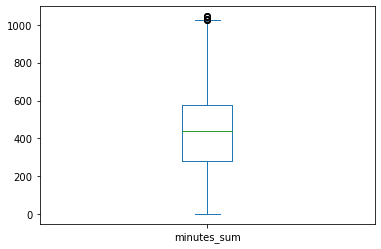

In [12]:
filter_quantile(calls_groupied,'minutes_sum', plot=True)#выводим "ящик с усами" и границы межквартильного интервала

print(f'Среднее количество минут использоавнное пользователями тарифа smart: {calls_groupied[calls_groupied["tariff"] == "smart"]["minutes_sum"].mean()}')#Среднее
print(f'Среднее количество минут использоавнное пользователями тарифа "ultra": {calls_groupied[calls_groupied["tariff"] == "ultra"]["minutes_sum"].mean()}')#Среднее
print(f'Медиана: {calls_groupied["minutes_sum"].median()}')#Медиана
print(f'Дисперсия: {np.var(calls_groupied["minutes_sum"], ddof=1)}')# Дисперсия
print(f'Стандартное отклонение: {np.std(calls_groupied["minutes_sum"], ddof=1)}')#Стандартное отклонение
print(f'Минимум: {calls_groupied["minutes_sum"].min()}')#Минимальное значение 
print(f'Максимум: {calls_groupied["minutes_sum"].max()}')#Максимальное значение 
print(calls_groupied["minutes_sum"].describe())#Проверяем другим способом, чисто попробовать как работает к столбцу 
print(calls_groupied.pivot_table(index='tariff', columns='month', values='minutes_sum',aggfunc='mean'))#Выводим сводную таблицу средних количеств минут для каждого тарифа по месяцам 

AxesSubplot(0.125,0.125;0.775x0.755)


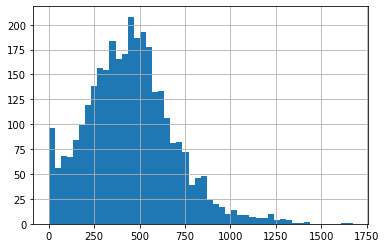

In [13]:
print(calls_groupied["minutes_sum"].hist(bins=50))#Строим гистограмму для визуализации использования сотовой связи 

В целом, данные распределены нормально.

Средний пользователь тарифа smart использует в месяц 400 минут сотовой связи

Средний пользователь тарифа ultra использует в месяц 500 минут сотовой связи


Теперь проделаем всё тоже самое для остальных интересующих нас столбцов

Процент выбросов: 2.83%
Верхний порог: 129.0
Нижний порог: -63.0
Среднее количество минут использоавнное пользователями тарифа smart: 33.384028712427096
Среднее количество минут использоавнное пользователями тарифа "ultra": 49.36345177664975
Медиана: 30.0
Дисперсия: 1306.701441774252
Стандартное отклонение: 36.14832557358988
Минимум: 0
Максимум: 224
count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages_count, dtype: float64


month,1,2,3,4,5,6,7,8,9,10,11,12
tariff,,,,,,,,,,,,
smart,18.235294,24.086207,31.857143,30.741071,33.773050,33.402439,33.751244,33.638298,33.638462,33.765306,34.075949,35.994065
ultra,33.777778,21.958333,32.297297,31.563636,37.850746,41.726190,49.846154,48.439252,52.286957,58.430894,55.791045,60.611511


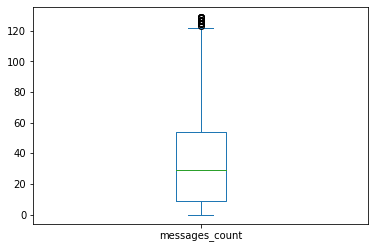

In [14]:
filter_quantile(calls_groupied,"messages_count", plot=True)
print(f'Среднее количество минут использоавнное пользователями тарифа smart: {calls_groupied[calls_groupied["tariff"] == "smart"]["messages_count"].mean()}')#Среднее
print(f'Среднее количество минут использоавнное пользователями тарифа "ultra": {calls_groupied[calls_groupied["tariff"] == "ultra"]["messages_count"].mean()}')#Среднее
print(f'Медиана: {calls_groupied["messages_count"].median()}')
print(f'Дисперсия: {np.var(calls_groupied["messages_count"], ddof=1)}')
print(f'Стандартное отклонение: {np.std(calls_groupied["messages_count"], ddof=1)}')
print(f'Минимум: {calls_groupied["messages_count"].min()}')
print(f'Максимум: {calls_groupied["messages_count"].max()}')
print(calls_groupied["messages_count"].describe())
display(calls_groupied.pivot_table(index='tariff', columns='month', values='messages_count',aggfunc='mean'))

AxesSubplot(0.125,0.125;0.775x0.755)


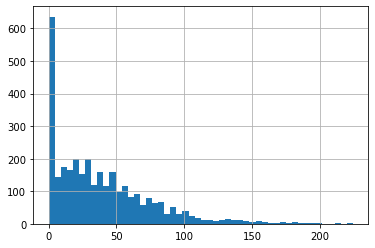

In [15]:
print(calls_groupied["messages_count"].hist(bins=50))

Количество нулевых занчений я бы объяснил отсутствием интереса к смс из-за обилия мессенджеров, ну и замена пропусков на нули.

В остальном распределение нормальное, ярко выраженного колокола нет из-за большого разброса данных.


Средний пользователь тарифа smart использует в месяц не более 35 смс.

Средний пользователь тарифа ultra использует в месяц не более 50 смс.

Процент выбросов: 2.40%
Верхний порог: 34823.7275
Нижний порог: -907.2125000000015
Среднее количество мегабайт интернет трафика использоавнное пользователями тарифа smart: 16208.38698968148
Среднее количество мегабайт интернет трафика использоавнное пользователями тарифа "ultra": 19468.805208121834
Медиана: 16943.175
Дисперсия: 57319416.71962482
Стандартное отклонение: 7570.958771491549
Минимум: 0.0
Максимум: 49745.69
count     3214.000000
mean     17207.612859
std       7570.958771
min          0.000000
25%      12491.890000
50%      16943.175000
75%      21424.625000
max      49745.690000
Name: mb_used, dtype: float64
month             1            2             3             4             5   \
tariff                                                                        
smart    8513.717647  11597.05431  15104.159091  13462.180625  15805.184326   
ultra   13140.681111  11775.93750  17535.550270  16828.134364  19363.152985   

month             6             7             8        

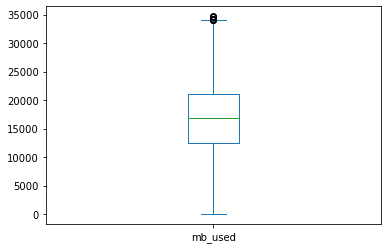

In [16]:
filter_quantile(calls_groupied,'mb_used', plot=True)
print(f'Среднее количество мегабайт интернет трафика использоавнное пользователями тарифа smart: {calls_groupied[calls_groupied["tariff"] == "smart"]["mb_used"].mean()}')#Среднее
print(f'Среднее количество мегабайт интернет трафика использоавнное пользователями тарифа "ultra": {calls_groupied[calls_groupied["tariff"] == "ultra"]["mb_used"].mean()}')#Среднее
print(f'Медиана: {calls_groupied["mb_used"].median()}')
print(f'Дисперсия: {np.var(calls_groupied["mb_used"], ddof=1)}')
print(f'Стандартное отклонение: {np.std(calls_groupied["mb_used"], ddof=1)}')
print(f'Минимум: {calls_groupied["mb_used"].min()}')
print(f'Максимум: {calls_groupied["mb_used"].max()}')
print(calls_groupied["mb_used"].describe())
print(calls_groupied.pivot_table(index='tariff', columns='month', values='mb_used',aggfunc='mean'))


AxesSubplot(0.125,0.125;0.775x0.755)


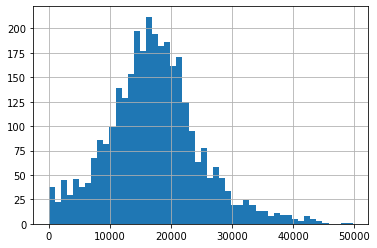

In [17]:
print(calls_groupied["mb_used"].hist(bins=50))

Распределение нормальное.

Средний пользователь тарифа smart использует в месяц около 16000 мегабайт интернет трафика

Средний пользователь тарифа ultra использует в месяц около 20000 мегабайт интернет трафика

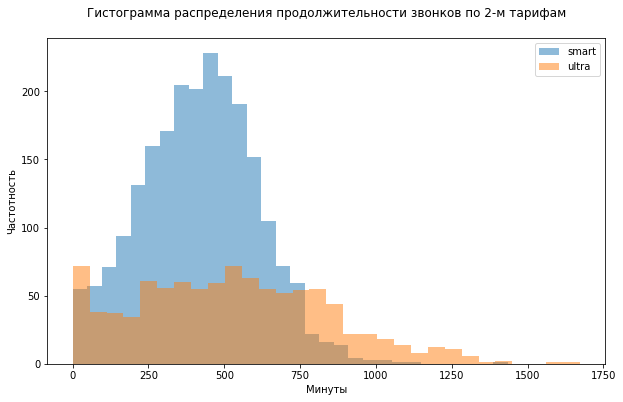

In [18]:

from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
calls_groupied['minutes_sum'][calls_groupied['tariff'] == 'smart'].plot(kind='hist', alpha=0.5, bins=30)
calls_groupied['minutes_sum'][calls_groupied['tariff'] == 'ultra'].plot(kind='hist', alpha=0.5, bins=30)
plt.title('Гистограмма распределения продолжительности звонков по 2-м тарифам'+ "\n")
plt.xlabel('Минуты')
plt.ylabel('Частотность')
plt.legend(['smart', 'ultra'])
plt.show()

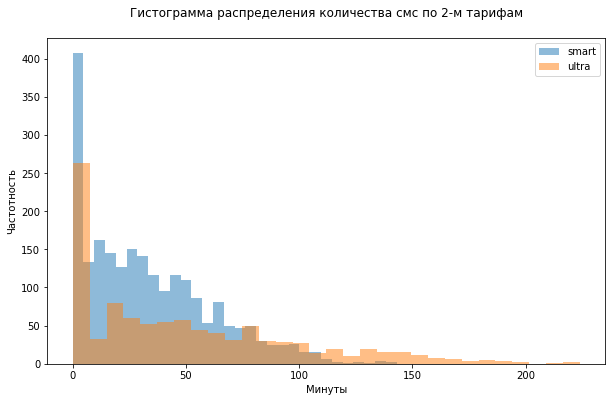

In [19]:
plt.figure(figsize=(10, 6))
calls_groupied['messages_count'][calls_groupied['tariff'] == 'smart'].plot(kind='hist', alpha=0.5, bins=30)
calls_groupied['messages_count'][calls_groupied['tariff'] == 'ultra'].plot(kind='hist', alpha=0.5, bins=30)
plt.title('Гистограмма распределения количества смс по 2-м тарифам'+ "\n")
plt.xlabel('Минуты')
plt.ylabel('Частотность')
plt.legend(['smart', 'ultra'])
plt.show()

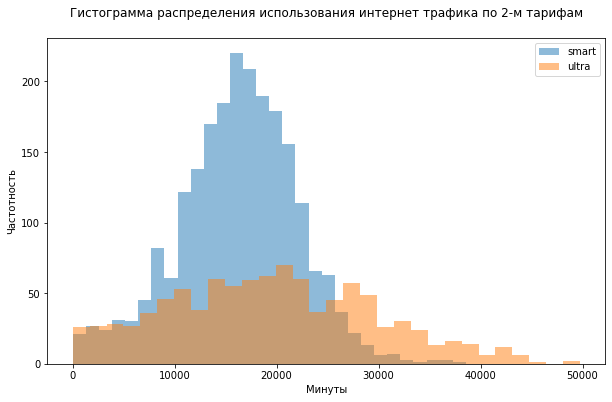

In [20]:
plt.figure(figsize=(10, 6))
calls_groupied['mb_used'][calls_groupied['tariff'] == 'smart'].plot(kind='hist', alpha=0.5, bins=30)
calls_groupied['mb_used'][calls_groupied['tariff'] == 'ultra'].plot(kind='hist', alpha=0.5, bins=30)
plt.title('Гистограмма распределения использования интернет трафика по 2-м тарифам'+ "\n")
plt.xlabel('Минуты')
plt.ylabel('Частотность')
plt.legend(['smart', 'ultra'])
plt.show()

Пишем функцию для подсчёта выручки.

In [21]:
def calc_profit(data):
    if data['tariff'] == 'smart':
        smart_minutes_extra = data['minutes_sum'] - tariffs.loc[0, 'minutes_included']
        smart_messages_extra = data['messages_count'] - tariffs.loc[0, 'messages_included']
        smart_gb_used = data['mb_used'] / 1024
        smart_gb_extra = smart_gb_used - (tariffs.loc[0, 'mb_per_month_included'] / 1024)
        if smart_gb_extra > 0:
            smart_user_profit_for_internet = np.ceil(smart_gb_extra) * tariffs.loc[0, 'rub_per_gb']
        else:
            smart_user_profit_for_internet = 0
        if smart_minutes_extra > 0:
            smart_user_profit_for_calls = smart_minutes_extra * tariffs.loc[0,'rub_per_minute']
        else:
            smart_user_profit_for_calls = 0
        if smart_messages_extra > 0:
            smart_user_profit_for_messages = smart_minutes_extra * tariffs.loc[0,'rub_per_message']
        else:
            smart_user_profit_for_messages = 0
        return tariffs.loc[0,'rub_monthly_fee'] + smart_user_profit_for_internet + smart_user_profit_for_calls + smart_user_profit_for_messages
            
        
    else:
        ultra_minutes_extra = data['minutes_sum'] - tariffs.loc[1, 'minutes_included']
        ultra_messages_extra = data['messages_count'] - tariffs.loc[1, 'messages_included']
        ultra_gb_used = data['mb_used'] / 1024
        ultra_gb_extra = ultra_gb_used - (tariffs.loc[1, 'mb_per_month_included'] / 1024)
        if ultra_gb_extra > 0:
            ultra_user_profit_for_internet = np.ceil(ultra_gb_extra) * tariffs.loc[0, 'rub_per_gb']
        else:
            ultra_user_profit_for_internet = 0
        if ultra_minutes_extra > 0:
            ultra_user_profit_for_calls = ultra_minutes_extra * tariffs.loc[1,'rub_per_minute']
        else:
            ultra_user_profit_for_calls = 0
        if ultra_messages_extra > 0:
            ultra_user_profit_for_messages = ultra_minutes_extra * tariffs.loc[1,'rub_per_message']
        else:
            ultra_user_profit_for_messages = 0
        return tariffs.loc[1,'rub_monthly_fee'] + ultra_user_profit_for_internet + ultra_user_profit_for_calls + ultra_user_profit_for_messages

Применяем её к нашей сборной таблице методом apply и сохраняем в новом столбце

In [22]:
calls_groupied['profit_for_user'] = calls_groupied.apply(calc_profit, axis=1)
display(calls_groupied.tail(50))


,user_id,month,calls,minutes_sum,mb_used,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff,profit_for_user
3164,1496,12,80.0,518,20736.15,51,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,1858.0
3165,1497,10,66.0,490,11500.29,20,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,550.0
3166,1497,11,64.0,371,14156.08,14,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,550.0
3167,1497,12,71.0,545,19918.60,17,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,1685.0
3168,1498,7,23.0,175,7476.24,20,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,550.0
3169,1498,8,57.0,400,24235.21,62,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2050.0
3170,1498,9,59.0,471,22134.41,44,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,1950.0
3171,1498,10,41.0,247,20579.36,42,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,1750.0
3172,1499,9,9.0,70,1845.75,11,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,550.0
3173,1499,10,68.0,449,17788.51,48,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,1150.0


Выведем средние количества потраченных минут, смс, мегабайт по каждому тарифу за год

In [23]:
display('Среднее количеств принесенных денег пользователем тарифе "ultra":', calls_groupied[calls_groupied['tariff'] == 'ultra']['profit_for_user'].mean())
display('Среднее количеств принесенных денег пользователем тарифе "smart":', calls_groupied[calls_groupied['tariff'] == 'smart']['profit_for_user'].mean())
display('Среднее количества потраченных минут на тарифе "ultra":', calls_groupied[calls_groupied['tariff'] == 'ultra']['minutes_sum'].mean())
display('Среднее количества потраченных минут на тарифе "smart":', calls_groupied[calls_groupied['tariff'] == 'smart']['minutes_sum'].mean())
display('Среднее количества потраченных мегабайт интернета на тарифе "ultra":', calls_groupied[calls_groupied['tariff'] == 'ultra']['mb_used'].mean())
display('Среднее количества потраченных мегабайт интернета на тарифе "smart":', calls_groupied[calls_groupied['tariff'] == 'smart']['mb_used'].mean())
display('Среднее количества отправленных пользователем сообщений на тарифе "ultra":', calls_groupied[calls_groupied['tariff'] == 'ultra']['messages_count'].mean())
display('Среднее количества отправленных пользователем сообщений на тарифе "smart":', calls_groupied[calls_groupied['tariff'] == 'smart']['messages_count'].mean())

'Среднее количеств принесенных денег пользователем тарифе "ultra":'

2110.203045685279

'Среднее количеств принесенных денег пользователем тарифе "smart":'

1256.2157918349035

'Среднее количества потраченных минут на тарифе "ultra":'

526.6233502538071

'Среднее количества потраченных минут на тарифе "smart":'

417.9349484073576

'Среднее количества потраченных мегабайт интернета на тарифе "ultra":'

19468.805208121834

'Среднее количества потраченных мегабайт интернета на тарифе "smart":'

16208.38698968148

'Среднее количества отправленных пользователем сообщений на тарифе "ultra":'

49.36345177664975

'Среднее количества отправленных пользователем сообщений на тарифе "smart":'

33.384028712427096

## Проверка гипотез<a id="fourth"></a>

### Проверка первой гипотезы о равности средних выручек обоих тарифов

Формулируем нулевую и альтернативную гипотезу:

Н0 = Средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей траифа «Смарт»

H1 = Средняя выручка пользователей тарифа «Ультра» отличается от средней выручки пользователей траифа «Смарт»

In [24]:
sample_users_smart_count = int(calls_groupied[calls_groupied['tariff'] == 'smart']['profit_for_user'].count())#смторим размер выборки из средних выручек пользователей траифа «Смарт»
sample_users_ultra_count = int(calls_groupied[calls_groupied['tariff'] == 'ultra']['profit_for_user'].count())#смторим размер выборки из средних выручек пользователей траифа «Ультра»
print(f'Размер выборки средней выручки пользователей тарифа "Ультра": {sample_users_ultra_count}')#Выводим результат
print(f'Размер выборки средней выручки пользователей тарифа "Смарт": {sample_users_smart_count}')#Выводим результат


alpha = 0.05# коэффициент значимости установим в 5%



results = st.ttest_ind(
    calls_groupied[calls_groupied['tariff'] == 'ultra']['profit_for_user'],
    calls_groupied[calls_groupied['tariff'] == 'smart']['profit_for_user'],
    equal_var = False
)#Проводим ttest между двумя выборками разных размеров

print('p-value:', results.pvalue)#Гипотеза двусторонняя, p-value целое

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Размер выборки средней выручки пользователей тарифа "Ультра": 985
Размер выборки средней выручки пользователей тарифа "Смарт": 2229
p-value: 3.7773690876612094e-220
Отвергаем нулевую гипотезу.


### Проверка второй гипотезы об отличии средней выручки пользователей из москвы Москвы от средней выручки пользователей из других регионов

Формулируем нулевую и альтернативную гипотезу:

Н0 = Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов

H1 = Средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других регионов

In [25]:
sample_users_moscow_count = calls_groupied[calls_groupied['city'] == 'Москва']['profit_for_user'].count()#смторим размер выборки из средних выручек пользователей из Москвы 
sample_users_not_from_moscow_count = calls_groupied[calls_groupied['city'] != 'Москва']['profit_for_user'].count()#смторим размер выборки из средних выручек пользователей не из Москвы
print('Размер выборки срейдней выручки пользователей из Москвы:', sample_users_moscow_count)#выводим результаты
print('Размер выборки срейдней выручки пользователей из других регионов:', sample_users_not_from_moscow_count)#выводим результаты

alpha = .05# коэффициент значимости установим в 5%

result = st.ttest_ind(
    calls_groupied[calls_groupied['city'] == 'Москва']['profit_for_user'],
    calls_groupied[calls_groupied['city'] != 'Москва']['profit_for_user'],
    equal_var=False
)#Проводим ttest между двумя выборками разных размеров

print('p-value:', result.pvalue)#Гипотеза двусторонняя, p-value целое

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

Размер выборки срейдней выручки пользователей из Москвы: 611
Размер выборки срейдней выручки пользователей из других регионов: 2603
p-value: 0.24937605834631194
Не удалось отвергнуть нулевую гипотезу


Нулевая гипотеза подбиралась из соображений наличия знака "равно".

Альтернативные гипотезы в обоих случаях двусторонние, потому p-value не делится на 2.

Параметр equal_var=False прописывался из-за того, что выборки разные по размеру.



## Общий вывод<a id="fifth"></a>


Исходя из полученных данных можно сказать, что сообщения нынче отправлять не в моде, видимо в силу наличия мессенджеров и соцсетей с чатами. В звонках тоже были пропуски(нули), видмо эти люди брали сим-карты для планшетов. Интернетом пользуются практически все.
Средний пользователь тарифа ultra приносит 2110 рублей
Средний пользователь тарифа smart приносит 1256 рублей
Средний пользователь тарифа ultra использует в месяц 526 минут сотовой связи
Средний пользователь тарифа smart использует в месяц 417 минут сотовой связи
Средний пользователь тарифа ultra использует в месяц 19468 мегабайт интернета
Средний пользователь тарифа smart использует в месяц 16208 мегабайт интернета
Средний пользователь тарифа ultra отправляет в месяц 49 сообщения
Средний пользователь тарифа smart отправляет в месяц 33 сообщения

Средние выборочные выручки тарифов отличаются достаточно существенно: smart - 1256 рублей, ultra - 2110 рублей.
Проверка гипотез показала, что:
1. Генеральные средние выручки тарифов smart и ultra скорей всего не равны (p-value 3.78)
2. Генеральные средние выручки пользователей из Москвы вероятнее всего не отличаются от генеральной средней выручки других регионов(нулевая гипотеза о их равенстве отвергнута на основании p-value 0.25 при alpha 5%)


**Тариф ultra приносит больше денег, заказчику рекомендуем больший упор в рекламе сделать на него!**